In [5]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [7]:
%cd '/content/drive/MyDrive/DATA 245/Project'

/content/drive/.shortcut-targets-by-id/1dBaisw15vXAkSJcnz0pO83MeXqW6AHFn/DATA 245/Project


In [8]:
# Read the pickle file
file_path = '02 artifacts/processed_dataset_WQ.pkl'
try:
    df_pickle = pd.read_pickle(file_path)
    print(f"Successfully read '{file_path}'")
    display(df_pickle.head())
except FileNotFoundError:
    print(f"File not found at {file_path}. Please check the path.")
except Exception as e:
    print(f"An error occurred: {e}")

Successfully read '02 artifacts/processed_dataset_WQ.pkl'


,station_id,station_name,station_number,full_station_name,station_type,latitude,longitude,county_name,sample_code,sample_date,...,Turbidity_NTU,WaterTemperature_°C,pH_pH units,qi_DO,qi_pH,qi_Cond,qi_Turb,qi_Temp,WQI,WQI_Class
0,1,AMERICAN,A0714010,American River at Water Treatment Plant,Surface Water,38.5596,-121.4169,Sacramento,C0114B0005,2014-01-06 12:14:00,...,2.28,10.18,7.60,87.000000,100.0,95.600000,97.72,50.90,89.854000,Good
1,1,AMERICAN,A0714010,American River at Water Treatment Plant,Surface Water,38.5596,-121.4169,Sacramento,C0115B0005,2015-01-05 11:53:00,...,1.41,10.75,7.91,83.857143,100.0,94.666667,98.59,53.75,89.183476,Good
2,1,AMERICAN,A0714010,American River at Water Treatment Plant,Surface Water,38.5596,-121.4169,Sacramento,C0117B0081,2017-01-10 14:00:00,...,160.00,9.24,7.26,93.142857,100.0,96.533333,0.00,46.20,71.869524,Moderate
3,1,AMERICAN,A0714010,American River at Water Treatment Plant,Surface Water,38.5596,-121.4169,Sacramento,C0118B0005,2018-01-08 11:40:00,...,3.00,10.80,8.36,79.428571,100.0,96.600000,97.00,54.00,87.948571,Good
4,1,AMERICAN,A0714010,American River at Water Treatment Plant,Surface Water,38.5596,-121.4169,Sacramento,C0119B0011,2019-01-07 14:15:00,...,2.10,11.00,7.71,81.857143,100.0,95.680000,97.90,55.00,88.773143,Good


In [9]:
feature_cols = [
    'DissolvedOxygen_mg/L',
    'SpecificConductance_µS/cm',
    'Turbidity_NTU',
    'WaterTemperature_°C',
    'pH_pH units'
]
df_reg = df_pickle[feature_cols]

In [10]:
df_reg.head()

,DissolvedOxygen_mg/L,SpecificConductance_µS/cm,Turbidity_NTU,WaterTemperature_°C,pH_pH units
0,12.18,66.0,2.28,10.18,7.60
1,11.74,80.0,1.41,10.75,7.91
2,13.04,52.0,160.00,9.24,7.26
3,11.12,51.0,3.00,10.80,8.36
4,11.46,64.8,2.10,11.00,7.71


In [11]:
df_reg.describe()

,DissolvedOxygen_mg/L,SpecificConductance_µS/cm,Turbidity_NTU,WaterTemperature_°C,pH_pH units
count,53697.000000,53697.000000,53697.000000,53697.000000,53697.000000
mean,8.770840,1941.902500,13.277150,16.973959,7.743834
std,1.873375,5865.702142,29.055953,5.254148,0.486194
min,0.000000,0.000000,0.000000,-0.100000,0.000000
25%,8.050000,181.000000,5.100000,12.700000,7.500000
50%,8.860000,375.000000,7.800000,17.200000,7.710000
75%,9.700000,671.000000,11.600000,21.200000,7.940000
max,20.000000,48600.000000,1000.000000,50.000000,14.000000


In [12]:
df_reg.isnull().sum()

,0
DissolvedOxygen_mg/L,0
SpecificConductance_µS/cm,0
Turbidity_NTU,0
WaterTemperature_°C,0
pH_pH units,0


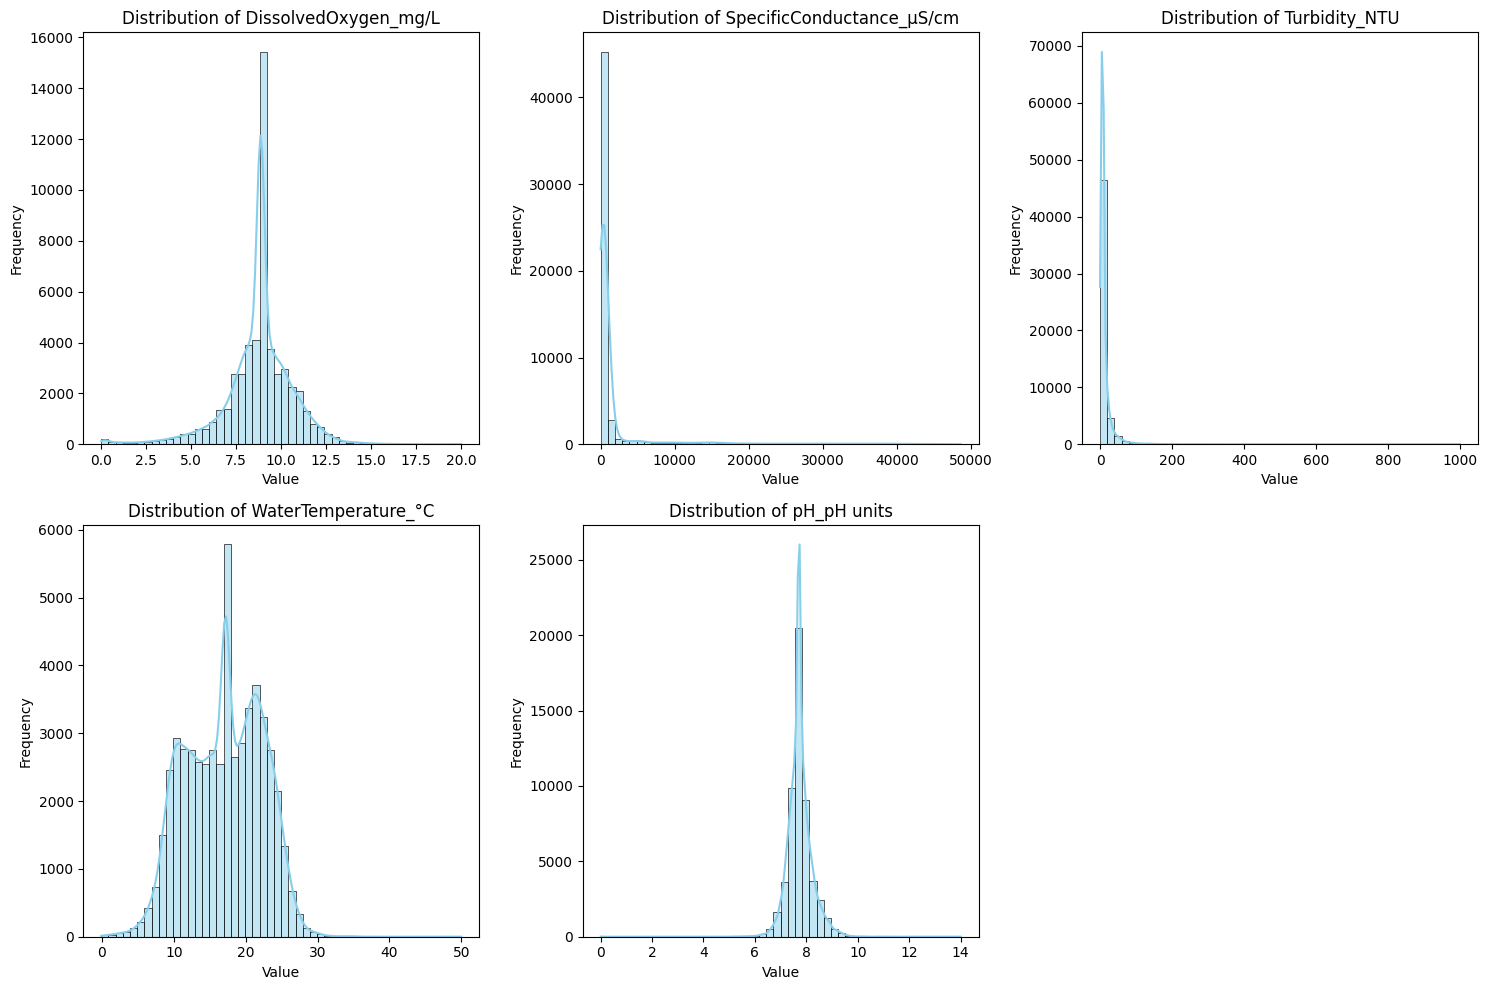

In [24]:
plt.figure(figsize=(15, 10))
for i, col in enumerate(feature_cols):
    plt.subplot(2, 3, i + 1)
    data = df_reg[col].dropna()
    # Using sns.histplot with more bins (50) and KDE helps visualize skewness
    sns.histplot(data, bins=50, kde=True, color='skyblue', edgecolor='black')
    plt.title(f'Distribution of {col}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [27]:
skew_turbidity = df_reg['Turbidity_NTU'].skew()
skew_conductance = df_reg['SpecificConductance_µS/cm'].skew()

print(f"Skewness for Turbidity_NTU: {skew_turbidity:.4f}")
print(f"Skewness for SpecificConductance_µS/cm: {skew_conductance:.4f}")

Skewness for Turbidity_NTU: 14.6614
Skewness for SpecificConductance_µS/cm: 4.6310


## Feature Engineering & Preprocessing

### Subtask:
Apply log-transformations to skewed features, create interaction terms, and perform standard scaling and train-test split.


In [28]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

df_processed = df_reg.copy()

df_processed['Turbidity_log'] = np.log1p(df_processed['Turbidity_NTU'])
df_processed['SpecificConductance_log'] = np.log1p(df_processed['SpecificConductance_µS/cm'])

df_processed['Temp_pH_interaction'] = df_processed['WaterTemperature_°C'] * df_processed['pH_pH units']

X = df_processed[['WaterTemperature_°C', 'pH_pH units', 'Turbidity_log', 'SpecificConductance_log', 'Temp_pH_interaction']]
y = df_processed['DissolvedOxygen_mg/L']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 8. Print the shapes to verify the split
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (42957, 5)
X_test shape: (10740, 5)
y_train shape: (42957,)
y_test shape: (10740,)


In [29]:
X_train.head()

,WaterTemperature_°C,pH_pH units,Turbidity_log,SpecificConductance_log,Temp_pH_interaction
26982,23.15,7.37,2.057963,4.897840,170.6155
29096,10.92,7.50,3.201526,9.182969,81.9000
12214,12.30,8.10,2.174752,4.969813,99.6300
32667,20.90,7.80,2.630449,9.553292,163.0200
13424,19.40,8.06,0.438255,4.938065,156.3640


## Model Development

### Subtask:
Train and evaluate baseline Linear Regression (with Regularization) and advanced ensemble models (Random Forest, XGBoost) on the processed data.


In [30]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=0.01),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
}

results = []

print("Training and Evaluating Models...")
print("-" * 60)


for name, model in models.items():

    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    results.append({
        'Model': name,
        'RMSE': rmse,
        'R2 Score': r2
    })

    print(f"{name:20} | RMSE: {rmse:.4f} | R2: {r2:.4f}")

print("-" * 60)

results_df = pd.DataFrame(results)
display(results_df)

Training and Evaluating Models...
------------------------------------------------------------
Linear Regression    | RMSE: 1.6736 | R2: 0.2085
Ridge                | RMSE: 1.6736 | R2: 0.2085
Lasso                | RMSE: 1.6756 | R2: 0.2067
Random Forest        | RMSE: 1.5956 | R2: 0.2806
XGBoost              | RMSE: 1.5645 | R2: 0.3083
------------------------------------------------------------


,Model,RMSE,R2 Score
0,Linear Regression,1.673587,0.208540
1,Ridge,1.673585,0.208542
2,Lasso,1.675570,0.206663
3,Random Forest,1.595609,0.280575
4,XGBoost,1.564507,0.308348


## Hyperparameter Tuning

In [31]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Initialize XGBRegressor
xgb = XGBRegressor(random_state=42, n_jobs=-1)

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=3,
    scoring='neg_root_mean_squared_error',
    verbose=1,
    n_jobs=-1
)

# Fit the model
print("Performing Grid Search...")
grid_search.fit(X_train_scaled, y_train)

# Output the best parameters and score
print("\nBest Parameters found:", grid_search.best_params_)
print(f"Best CV RMSE: {-grid_search.best_score_:.4f}")

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
y_pred_tuned = best_model.predict(X_test_scaled)

rmse_tuned = np.sqrt(mean_squared_error(y_test, y_pred_tuned))
r2_tuned = r2_score(y_test, y_pred_tuned)

print(f"\nTuned XGBoost Test RMSE: {rmse_tuned:.4f}")
print(f"Tuned XGBoost Test R2: {r2_tuned:.4f}")

Performing Grid Search...
Fitting 3 folds for each of 108 candidates, totalling 324 fits

Best Parameters found: {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}
Best CV RMSE: 1.5605

Tuned XGBoost Test RMSE: 1.5572
Tuned XGBoost Test R2: 0.3148


## Rigorous Evaluation & Diagnostics

### Subtask:
Validate the best model (XGBoost) using cross-validation, analyze residuals for statistical assumptions, and determine feature importance.


Performing 5-Fold Cross-Validation on XGBoost...
Cross-Validation RMSE: 1.5603 ± 0.0169


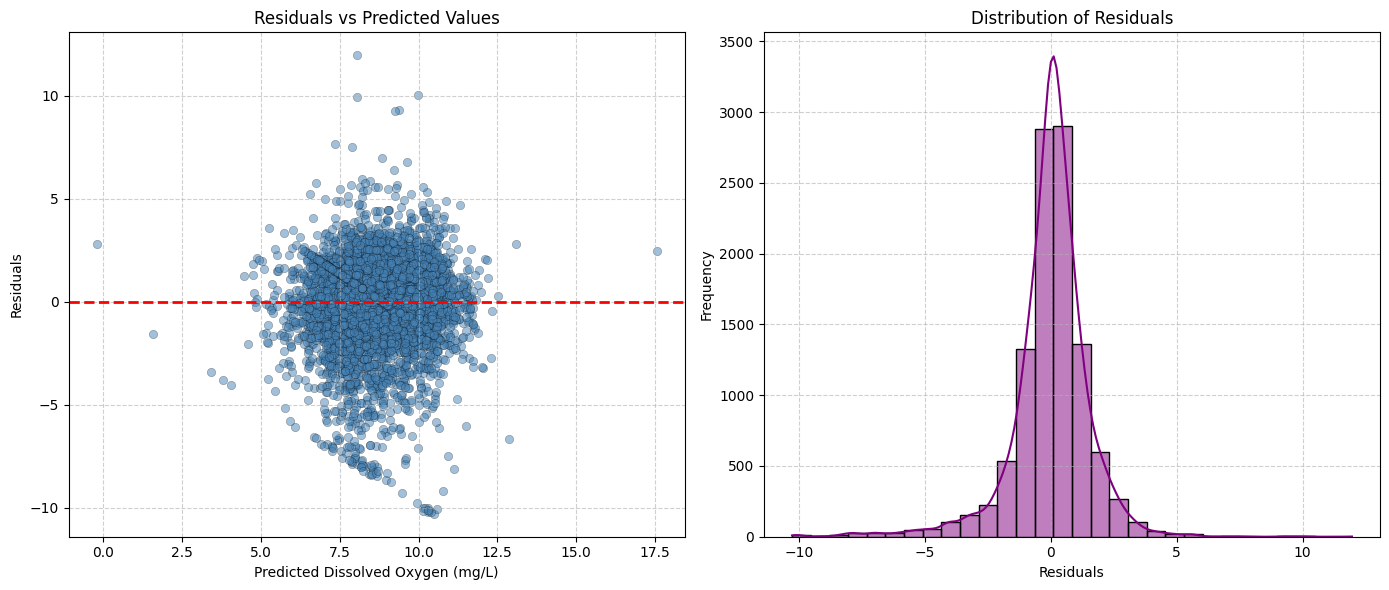

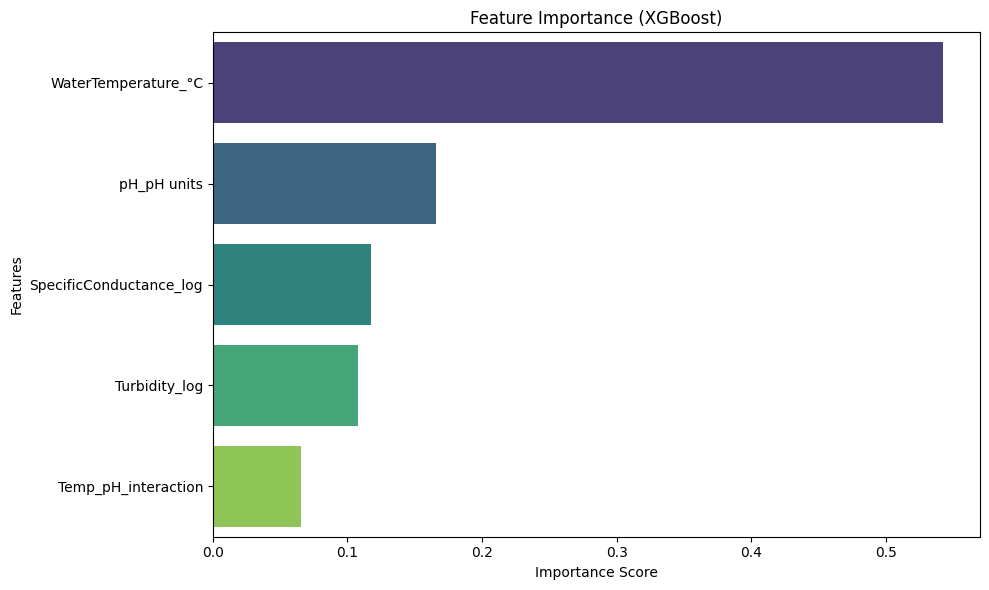

Feature Importance Ranking:


,Feature,Importance
0,WaterTemperature_°C,0.542913
1,pH_pH units,0.165988
3,SpecificConductance_log,0.117717
2,Turbidity_log,0.108020
4,Temp_pH_interaction,0.065362


In [32]:
from sklearn.model_selection import cross_val_score

# 1. Retrieve the trained XGBoost model
xgb_model = models['XGBoost']

# 2. Perform 5-fold Cross-Validation
print("Performing 5-Fold Cross-Validation on XGBoost...")
cv_scores = cross_val_score(xgb_model, X_train_scaled, y_train, cv=5, scoring='neg_root_mean_squared_error')
cv_rmse_scores = -cv_scores
print(f"Cross-Validation RMSE: {cv_rmse_scores.mean():.4f} ± {cv_rmse_scores.std():.4f}")

# 3. Residual Analysis
y_pred_xgb = xgb_model.predict(X_test_scaled)
residuals = y_test - y_pred_xgb

plt.figure(figsize=(14, 6))

# Subplot 1: Predicted vs Residuals
plt.subplot(1, 2, 1)
plt.scatter(y_pred_xgb, residuals, alpha=0.5, color='steelblue', edgecolor='k', linewidth=0.3)
plt.axhline(0, color='red', linestyle='--', linewidth=2)
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted Dissolved Oxygen (mg/L)')
plt.ylabel('Residuals')
plt.grid(True, linestyle='--', alpha=0.6)

# Subplot 2: Histogram of Residuals
plt.subplot(1, 2, 2)
sns.histplot(residuals, kde=True, color='purple', bins=30)
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

# 4. Feature Importance
feature_names = X.columns
importances = xgb_model.feature_importances_
feature_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_imp_df = feature_imp_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_imp_df, hue='Feature', palette='viridis', legend=False)
plt.title('Feature Importance (XGBoost)')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

print("Feature Importance Ranking:")
display(feature_imp_df)

## Final Task

### Subtask:
Summarize the model selection results and justify the best-performing model.


## Summary:

### Q&A

**Question:** Summarize the model selection results and justify the best-performing model.

**Answer:**
Five regression models were evaluated to predict Dissolved Oxygen: Linear Regression, Ridge, Lasso, Random Forest, and XGBoost. The linear baseline models (Linear, Ridge, Lasso) performed similarly with an RMSE of approximately 1.67 and an $R^2$ of 0.21. Ensemble methods significantly outperformed the linear baselines. **XGBoost** was identified as the best-performing model, achieving the lowest RMSE (**1.5645**) and the highest $R^2$ score (**0.3083**), compared to Random Forest (RMSE: 1.5956, $R^2$: 0.2806). The selection of XGBoost is further justified by its stability during 5-fold cross-validation (Mean RMSE: 1.5603 $\pm$ 0.0169).

### Data Analysis Key Findings

*   **Data Distribution & Preprocessing**:
    *   **Turbidity** and **Specific Conductance** exhibited high right-skewness with skewness values of **14.66** and **4.63** respectively. This was addressed using log-transformations (`np.log1p`).
    *   **Water Temperature** displayed a multimodal distribution, indicating potential seasonal or spatial sub-groupings.
*   **Feature Engineering**:
    *   Interaction terms were created, specifically `Temp_pH_interaction`, to capture non-linear dependencies.
    *   The dataset was split 80/20 (Train: 42,957 samples, Test: 10,740 samples) and scaled using `StandardScaler`.
*   **Model Performance**:
    *   **XGBoost** achieved the best predictive performance with an RMSE of **1.5645** and $R^2$ of **0.3083**, outperforming the Linear Regression baseline ($R^2$ ~0.21) by a significant margin.
*   **Feature Importance**:
    *   **Water Temperature** is the dominant driver for Dissolved Oxygen predictions, holding a feature importance score of **0.54**.
    *   Secondary drivers include **pH** (0.17) and the log-transformed **Specific Conductance** (0.12).

### Insights or Next Steps

*   **Model Limitations**: Despite XGBoost being the best model, the $R^2$ of **0.3083** indicates that approximately 70% of the variance in Dissolved Oxygen is unexplained by the current physicochemical features.
*   **Next Steps**: To address the low explained variance and the "temporal non-stationarity" identified in the literature review, future iterations should incorporate **temporal features** (e.g., lagged variables, rolling averages, seasonality indicators) or **spatial features** to capture the complex environmental dynamics better.
